## Google Colab setup (don't run locally)

In [1]:
from google.colab import drive
import os
import shutil

# Mount drive to colab
drive.mount('/content/drive', force_remount=True)

# setting up paths
path_to_project_files = '/content/drive/MyDrive/GaTech/2025 1Spring/DL/DeepLearning'
existing = os.path.join(path_to_project_files, 'kaggle.json')
path_to_colab_utils = '/root/.kaggle'
target = os.path.join(path_to_colab_utils, 'kaggle.json')

# move the key to the colab root
os.makedirs(path_to_colab_utils, exist_ok=True)
shutil.copy(existing, target)
os.chmod(target, 600)

# download the data into /content (which is temporary)
!kaggle datasets download -d xhlulu/leafsnap-dataset -p /content --unzip

Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/xhlulu/leafsnap-dataset
License(s): copyright-authors


In [2]:
import sys

# Edit this path to where you've uploaded the repo files, so the imports work.
sys.path.append('/content/drive/MyDrive/GaTech/2025 1Spring/DL/DeepLearning')

## Library Imports

In [3]:
from autoencoder import *
from dataloader import *

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import os

In [4]:
import matplotlib.pyplot as plt

def showTensorInNotebook(tensor):
    """
    This takes a (3[RGB], H, W) tensor in R[0.0, 1.0] and displays it with matplotlib.
    """
    image = tensor.detach().cpu().numpy().transpose(1,2,0) # move the channel axis to the end, because PIL and matplotlib hate each other
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Building the data loader

These are transforms that allow us to ingest the image tensors with some extra confusion at training time. `processor` makes the data loader spit out tensors, and `noiser` adds Gaussian noise.

In [6]:
# This just processes the images.
H, W = 400, 400
processor = v2.Compose([
    v2.PILToTensor(), # the LeafsnapDataset class gives PIL Images, convert to torch Tensor
    v2.Resize((H, W)), # resize
    lambda x: x / 255.0, # convert N[0, 255] to R[0.0, 1.0]
])
BATCH_SIZE = 32

# This adds the noise for training.
NOISE_RATIO = 0.1
noiser = v2.Compose([
    lambda x: torch.clip(x + NOISE_RATIO*torch.randn_like(x), 0.0, 1.0) # add the noise
])

In [7]:
root_directory = os.path.join(os.getcwd(), 'leafsnap-dataset') # you make need to edit this path to work, though, it works on Colab by default and works locally if you keep the dataset at the root of the repo
image_paths_file = os.path.join(root_directory, "leafsnap-dataset-images.txt")
dataset = LeafsnapDataset(image_paths_file, root_directory, use_segmented=False, source="field", transform=processor)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

## Training a fully convolutional autoencoder (CAE)

All hyperparameters are hard-coded in this model. A 3x400x400 image is bound to a dense encoding of 5000 features, using only convolution.

In [8]:
model = ConvolutionalAutoencoder((BATCH_SIZE, 3, 400, 400), noiser, device=device)

train_AE_model(model, dataloader, 20, 1e-4, device=device)

Epoch 1/20: 100%|██████████| 242/242 [03:33<00:00,  1.13it/s, batch=242/242, loss=0.00791]


Total epoch loss: 1.283062574453652


Epoch 2/20: 100%|██████████| 242/242 [03:35<00:00,  1.12it/s, batch=242/242, loss=0.0102]


Total epoch loss: 0.8087212975369766


Epoch 3/20: 100%|██████████| 242/242 [03:35<00:00,  1.12it/s, batch=242/242, loss=0.00416]


Total epoch loss: 0.7091229348443449


Epoch 4/20: 100%|██████████| 242/242 [03:34<00:00,  1.13it/s, batch=242/242, loss=0.00675]


Total epoch loss: 0.617940990254283


Epoch 5/20: 100%|██████████| 242/242 [03:34<00:00,  1.13it/s, batch=242/242, loss=0.00926]


Total epoch loss: 0.5998080821009353


Epoch 6/20: 100%|██████████| 242/242 [03:33<00:00,  1.13it/s, batch=242/242, loss=0.00365]


Total epoch loss: 0.5738384235883132


Epoch 7/20: 100%|██████████| 242/242 [03:34<00:00,  1.13it/s, batch=242/242, loss=0.0024]


Total epoch loss: 0.5607863634359092


Epoch 8/20: 100%|██████████| 242/242 [03:33<00:00,  1.13it/s, batch=242/242, loss=0.00592]


Total epoch loss: 0.577554136281833


Epoch 9/20: 100%|██████████| 242/242 [03:34<00:00,  1.13it/s, batch=242/242, loss=0.00555]


Total epoch loss: 0.5576522002229467


Epoch 10/20: 100%|██████████| 242/242 [03:33<00:00,  1.13it/s, batch=242/242, loss=0.00249]


Total epoch loss: 0.538376837503165


Epoch 11/20: 100%|██████████| 242/242 [03:34<00:00,  1.13it/s, batch=242/242, loss=0.00799]


Total epoch loss: 0.5222920317901298


Epoch 12/20: 100%|██████████| 242/242 [03:33<00:00,  1.13it/s, batch=242/242, loss=0.00243]


Total epoch loss: 0.5082140894373879


Epoch 13/20: 100%|██████████| 242/242 [03:34<00:00,  1.13it/s, batch=242/242, loss=0.00269]


Total epoch loss: 0.5136839478509501


Epoch 14/20: 100%|██████████| 242/242 [03:34<00:00,  1.13it/s, batch=242/242, loss=0.0024]


Total epoch loss: 0.5079512733500451


Epoch 15/20: 100%|██████████| 242/242 [03:34<00:00,  1.13it/s, batch=242/242, loss=0.0022]


Total epoch loss: 0.49755853589158505


Epoch 16/20: 100%|██████████| 242/242 [03:33<00:00,  1.13it/s, batch=242/242, loss=0.00824]


Total epoch loss: 0.5235945412423462


Epoch 17/20: 100%|██████████| 242/242 [03:33<00:00,  1.13it/s, batch=242/242, loss=0.00179]


Total epoch loss: 0.4980425335234031


Epoch 18/20: 100%|██████████| 242/242 [03:34<00:00,  1.13it/s, batch=242/242, loss=0.00302]


Total epoch loss: 0.47390218800865114


Epoch 19/20: 100%|██████████| 242/242 [03:34<00:00,  1.13it/s, batch=242/242, loss=0.00194]


Total epoch loss: 0.5036531334044412


Epoch 20/20: 100%|██████████| 242/242 [03:33<00:00,  1.13it/s, batch=242/242, loss=0.00672]

Total epoch loss: 0.5104751345934346


Now, a test run of the reconstruction

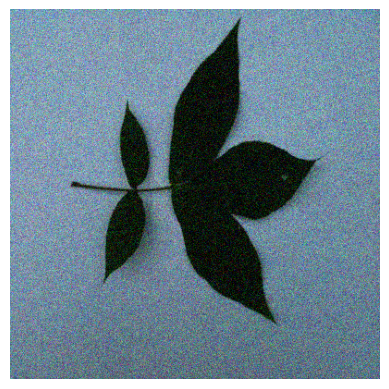

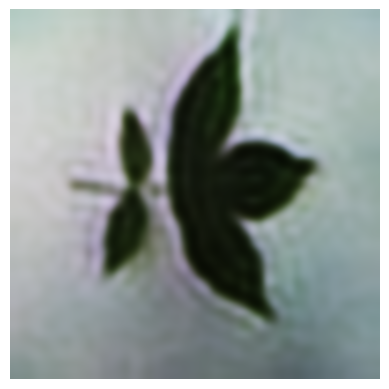

In [12]:
sample_train_image = noiser(dataset.__getitem__(1000)[0].unsqueeze(0)).to(device)
showTensorInNotebook(sample_train_image.squeeze(0))
reconstruction = model.forward(sample_train_image)
showTensorInNotebook(reconstruction.squeeze(0))

This is not a highly accurate reconstruction, but the noise is removed to some degree. These deep denoisers need quite a bit of data and only 7719 images is likely not enough. Hopefully we can source more data for this, but in the meantime, let's see how good a learned classifier is on this data.

In [14]:
torch.save(model.state_dict(), "CAE5k_model.pth")

## Building the classifier

In [15]:
trained_autoencoder = ConvolutionalAutoencoder((BATCH_SIZE, 3, 400, 400), noiser, device=device)
trained_autoencoder.load_state_dict(torch.load('CAE5k_model.pth'))
trained_autoencoder.eval()

classifier = AEClassifier(trained_autoencoder.encoder, [5000, 500, 185], device=device)
for param in classifier.encoder.parameters():
    param.requires_grad = False

train_classifier_head(classifier, dataloader, 10, 1e-3, device=device)

Epoch 1/10: 100%|██████████| 242/242 [01:14<00:00,  3.26it/s, batch=242/242, loss=5.23]


Total epoch loss: 1256.1529231071472


Epoch 2/10: 100%|██████████| 242/242 [01:14<00:00,  3.26it/s, batch=242/242, loss=5.23]


Total epoch loss: 1257.3401083946228


Epoch 3/10: 100%|██████████| 242/242 [01:14<00:00,  3.27it/s, batch=242/242, loss=5.23]


Total epoch loss: 1257.81986951828


Epoch 4/10: 100%|██████████| 242/242 [01:14<00:00,  3.26it/s, batch=242/242, loss=5.23]


Total epoch loss: 1260.0131492614746


Epoch 5/10: 100%|██████████| 242/242 [01:13<00:00,  3.27it/s, batch=242/242, loss=5.23]


Total epoch loss: 1259.8495678901672


Epoch 6/10: 100%|██████████| 242/242 [01:13<00:00,  3.27it/s, batch=242/242, loss=5.23]


Total epoch loss: 1259.4876427650452


Epoch 7/10: 100%|██████████| 242/242 [01:14<00:00,  3.27it/s, batch=242/242, loss=5.23]


Total epoch loss: 1259.9036135673523


Epoch 8/10: 100%|██████████| 242/242 [01:14<00:00,  3.24it/s, batch=242/242, loss=5.23]


Total epoch loss: 1259.5867075920105


Epoch 9/10: 100%|██████████| 242/242 [01:14<00:00,  3.26it/s, batch=242/242, loss=5.23]


Total epoch loss: 1259.5261874198914


Epoch 10/10: 100%|██████████| 242/242 [01:13<00:00,  3.30it/s, batch=242/242, loss=5.21]

Total epoch loss: 1259.3369946479797


In [16]:
correct_top1 = 0
correct_top5 = 0
total = 0

classifier.to(device)
with torch.no_grad(): # No gradients needed for evaluation
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = classifier(inputs)

        # Top-1 Accuracy
        _, predicted = torch.max(outputs, 1)
        correct_top1 += (predicted == labels).sum().item()

        # Top-5 Accuracy
        top5_preds = torch.topk(outputs, 5, dim=1).indices
        correct_top5 += torch.sum(top5_preds.eq(labels.view(-1, 1))).item()

        total += labels.size(0)

# Compute accuracies
top1_accuracy = 100 * correct_top1 / total
top5_accuracy = 100 * correct_top5 / total

print(f"Top-1 Accuracy: {top1_accuracy:.2f}%")
print(f"Top-5 Accuracy: {top5_accuracy:.2f}%")


Top-1 Accuracy: 2.60%
Top-5 Accuracy: 4.94%


Well, it looks like the embedding really isn't storing much rich data. My instinct tells me that from the way I've designed this network, the bottleneck is just a really scaled down version of the image, and the decoder is just a good upscaler. Which means that this accuracy is just a normal classifier on some 8-channel 25px by 25px version of the image, which is understandably bad.

This is supported by the fact that this architecture is inspired by that of the denoising autoencoder (DAE), which adds in skip connections to increase high-res fidelity during decoding. The key there is that their downstream task is actually denoising and infilling, which it seems to be decent at, not extracting an encoding.

I'd like to attempt some versions of the variational autoencoder technique, and the ViT Masked Autoencoder.

In [17]:
torch.save(classifier.state_dict(), "CAE_classifier.pth")